In [1]:
import seaborn as sns
import pandas as pd

df_16 = pd.read_csv("../results/16jobs_results.csv")
df_4 = pd.read_csv("../results/4jobs_results.csv")


In [2]:
df_16

,experiment,repetition,runtime,max_mem
0,lustre,0,74.89,1942844
1,lustre,0,75.42,1942156
2,mem_all,0,143.03,1961564
3,mem_final,0,184.31,1960364
4,lustre,1,54.58,1939564
5,mem_final,1,184.28,1958296
6,lustre,1,54.51,1942788
7,mem_all,1,143.67,1959804
8,lustre,2,70.98,1942112
9,mem_final,2,186.34,1958784


# Experiment 1 - 16 parallel jobs & 39 617MB images incremented 10 times (total data generated: ~234GiB)

(0.0, 193.0525)

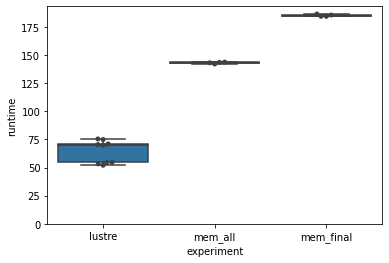

In [3]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_16)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_16, color=".25")
ax.set_ylim(bottom=0)

## Experiment 2 - 4 parallel jobs & 39 617MB images incremented 10 times (total data generated:~234GiB)

(0.0, 202.513)

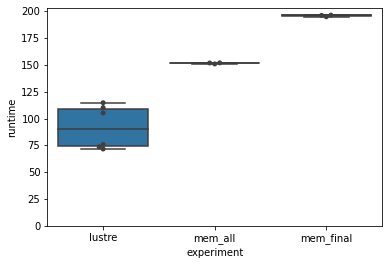

In [4]:
ax = sns.boxplot(x="experiment", y="runtime", data=df_4)
ax = sns.swarmplot(x="experiment", y="runtime", data=df_4, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 - 16 parallel jobs & Single node multidisk (all 6) & 39 617MB images incremented 10 times

In [5]:
multidisk = pd.read_csv("../results/multidisk_res.csv")
print(multidisk)
multidisk['flush_time_s'] = multidisk['flush_time'].apply(lambda x: float(x.strip('s').split('m')[1]) if pd.notnull(x) else 0)
multidisk['flush_time'] = multidisk['flush_time'].apply(lambda x: float(x.strip('s').split('m')[0])*60 if pd.notnull(x) else 0)
multidisk['flush_time_s'] = multidisk['flush_time'] + multidisk['flush_time_s']
multidisk['runtime'] = multidisk['runtime'].apply(lambda x: float(x))
multidisk = multidisk[['experiment', 'repetition', 'runtime', 'disk_files', 'total_flush', 'flush_time_s']]

  experiment  repetition  runtime  max_mem flush_time  disk_files  total_flush
0     lustre           0   102.23        0        NaN           0            0
1  mem_final           0    76.84        0   0m3.763s           0          352
2    mem_all           0   142.64        0  0m24.265s           0          391
3     lustre           1   114.60        0        NaN           0            0
4  mem_final           1    79.25        0   0m3.714s           0          355
5    mem_all           1   129.82        0  0m14.308s          13          391
6    mem_all           2   174.48        0  0m22.328s           0          391
7     lustre           2   114.53        0        NaN           0            0
8  mem_final           2    77.96        0   0m4.243s           0          352


In [6]:
multidisk

,experiment,repetition,runtime,disk_files,total_flush,flush_time_s
0,lustre,0,102.23,0,0,0.000
1,mem_final,0,76.84,0,352,3.763
2,mem_all,0,142.64,0,391,24.265
3,lustre,1,114.60,0,0,0.000
4,mem_final,1,79.25,0,355,3.714
5,mem_all,1,129.82,13,391,14.308
6,mem_all,2,174.48,0,391,22.328
7,lustre,2,114.53,0,0,0.000
8,mem_final,2,77.96,0,352,4.243


(0.0, 179.362)

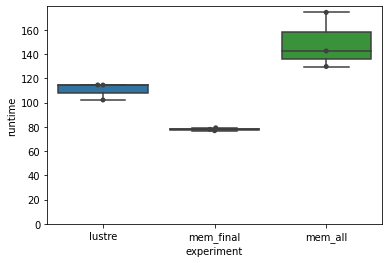

In [7]:
ax = sns.boxplot(x="experiment", y="runtime", data=multidisk)
ax = sns.swarmplot(x="experiment", y="runtime", data=multidisk, color=".25")
ax.set_ylim(bottom=0)

(0.0, 202.61825)

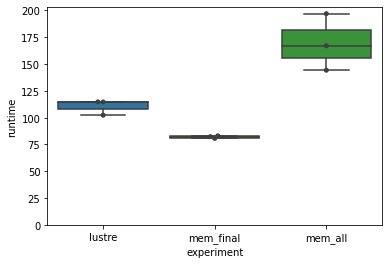

In [8]:
multidisk['runtime'] = multidisk['runtime'] + multidisk['flush_time_s']
ax = sns.boxplot(x="experiment", y="runtime", data=multidisk)
ax = sns.swarmplot(x="experiment", y="runtime", data=multidisk, color=".25")
ax.set_ylim(bottom=0)

## Experiment 3 Gantt Charts

In [130]:
colours = ["#c9d9d3", "#718dbf", "#e84d60"]

def bokeh_gantt(df):
    from bokeh.io import output_notebook, show
    from bokeh.models import ColumnDataSource, HoverTool, Legend, LegendItem
    from bokeh.plotting import figure
    
    output_notebook()
    y_range=sorted(df["pid"].unique())
    source_read = ColumnDataSource(df[df["action"].str.contains("read")])
    source_increment = ColumnDataSource(df[df["action"].str.contains("inc")])
    source_write = ColumnDataSource(df[df["action"].str.contains("save")])

    
    p = figure(toolbar_location="below", x_range=(0,130), y_range=y_range)
    p.hbar(y="pid", left="start", right="end", height=0.4,
           fill_color="color", source=source_read, legend_label="read")
    p.hbar(y="pid", left="start", right="end", height=0.4,
           fill_color="color", source=source_increment, legend_label="increment")
    p.hbar(y="pid", left="start", right="end", height=0.4,
           fill_color="color", source=source_write, legend_label="write")

    p.ygrid.grid_line_color = None
    p.xaxis.axis_label = "Time (seconds)"
    p.yaxis.axis_label = "PID"
    
    p.legend.click_policy = "hide"

    p.outline_line_color = None
    p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
        ('Task', '@action'),
        ('Image', '@img'),
        ('Start', '@start'),
        ('End', '@end'),
        ('Duration', "@duration")
    ]))
    
    show(p)
    
def bokeh_stacked(df):
    from bokeh.io import output_notebook, show
    from bokeh.models import ColumnDataSource, HoverTool, Legend, LegendItem, Whisker
    from bokeh.plotting import figure
    
    output_notebook()
    
    actions = ["read", "increment", "write"]
    source = ColumnDataSource(df)

    p = figure(x_range=df["type"], toolbar_location="below",
               tools="hover", tooltips=[("Task","$name"), ("Duration", "@$name")])

    p.vbar_stack(actions, x="type", width=0.9, fill_color=colours, source=source,
                 legend_label=actions)
    
    p.add_layout(
        Whisker(source=source, base="type", upper="read_upper", lower="read_lower", level="overlay"),
    )
    p.add_layout(
        Whisker(source=source, base="type", upper="inc_upper", lower="inc_lower", level="overlay")
    )
    p.add_layout(
        Whisker(source=source, base="type", upper="write_upper", lower="write_lower", level="overlay")
    )
    p.y_range.start = 0
    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.axis.minor_tick_line_color = None
    p.outline_line_color = None
    p.legend.orientation = "horizontal"
    p.legend.location="top_left"
    p.legend.click_policy="hide"

    show(p)
    
    
def action_columns_summ(df):
    
    df_read = (df[df['action'].str.contains('read')]
               .rename(columns={ "mean" : "read" }))


    df_increment = (df[df['action'].str.contains('inc')]
                    .rename(columns={ "mean" : "increment" }))

    
    df_write = (df[df['action'].str.contains('save')]
                .rename(columns={ "mean" : "write" }))

        
    df = pd.merge(df_read, df_increment, on=["type"])
    df = pd.merge(df, df_write, on=["type"])
    
    df['read_lower'] = df['read'] - df['std']
    df['read_upper'] = df['read'] + df['std']
    df['inc_lower'] = df['read'] + df['increment'] - df['std']
    df['inc_upper'] = df['read'] + df['increment'] + df['std']
    df['write_lower'] = df['read'] + df['increment'] + df['write'] - df['std']
    df['write_upper'] = df['read'] + df['increment'] + df['write'] + df['std']
    
    return df[["type", "read", "increment", "write", "read_lower",
               "read_upper", "inc_lower", "inc_upper", "write_lower", "write_upper"]]

def mean_std(df):
    df_mean =  df.groupby("action").mean().rename(columns={ "duration": "mean" }).reset_index()
    df_std = df.groupby("action").std().rename(columns={ "duration": "std" }).reset_index()
    df = pd.merge(df_mean, df_std, on=["repetition", "action"])   
    
    return df

    
def group_actions(in_mem_df, mem_flush_df, lustre_df):
    
    group = lambda df: (df[["repetition", "action", "duration"]]
                        .groupby(["repetition", "action"]).sum().reset_index())

    
    in_mem_df = group(in_mem_df)
    in_mem_df = mean_std(in_mem_df)
    in_mem_df["type"] = "Sea - In memory"
        
    mem_flush_df = group(mem_flush_df)
    mem_flush_df = mean_std(mem_flush_df)
    mem_flush_df["type"] = "Sea - Flush all"
    
    lustre_df = group(lustre_df)
    lustre_df = mean_std(lustre_df)
    lustre_df["type"] = "Lustre"
    
    df = pd.concat([in_mem_df, mem_flush_df, lustre_df], axis=0)
    
    return action_columns_summ(df)
    
    
def format_df(df, df_type):
    from datetime import datetime
    df = df[df["action"].str.contains(df_type)]
    #df['time'] = df['time'].apply(lambda x: datetime.fromtimestamp(x))
    df = df.rename(columns={"time": df_type})
    df["action"] = df["action"].apply(lambda x: x.split('_')[0])
    df["pid"] = df["pid"].astype("str") # % df["pid"].nunique()
    return df

def add_rep_idx(df_list):
    for i in range(len(df_list)):
        df_list[i]['repetition'] = i
        
    return df_list
    
def load_df(fn):
    from datetime import datetime
    df = pd.read_csv(fn, names=["action", "img", "time", "pid"], header=None)
    df_start = format_df(df, "start")
    df_end = format_df(df, "end")
    
    #df_end["end"] += 1
    
    #df_start["start"] = df_start["start"].apply(lambda x: datetime.fromtimestamp(x))
    #df_end["end"] = df_end["end"].apply(lambda x: datetime.fromtimestamp(x))
    
    df = pd.merge(df_start, df_end, on=["action","img", "pid"])
    df.loc[df["action"] == "read", "color"] = colours[0]
    df.loc[df["action"] == "inc", "color"] = colours[1]
    df.loc[df["action"] == "save", "color"] = colours[2]
    
    start_time = df["start"].min()
    df["start"] = df["start"] - start_time
    df["end"] = df["end"] - start_time
    df["duration"] = df["end"] - df["start"]
        
    return df


## Gantt Chart - Sea flush all files

In [131]:
fa_df = load_df("../results/mem_all-2/benchmarks.out")
bokeh_gantt(fa_df)

Loading BokehJS ...

## Gantt chart - Sea flush only final output (in-mem computing)

In [132]:
im_df = load_df("../results/mem_final-2/benchmarks.out")
bokeh_gantt(im_df)

Loading BokehJS ...

## Gantt chart - Write everything to Lustre

In [133]:
l_df = load_df("../results/lustre-2/benchmarks.out")
bokeh_gantt(l_df)

Loading BokehJS ...

In [134]:
im_files = ["../results/mem_final-0/benchmarks.out",
            "../results/mem_final-1/benchmarks.out",
            "../results/mem_final-2/benchmarks.out"]
fa_files = ["../results/mem_all-0/benchmarks.out",
            "../results/mem_all-1/benchmarks.out",
            "../results/mem_all-2/benchmarks.out"]
lustre_files = ["../results/lustre-0/benchmarks.out",
                "../results/lustre-1/benchmarks.out",
                "../results/lustre-2/benchmarks.out"]

load_files = lambda x: [load_df(f) for f in x]

im_dfs = load_files(im_files)
im_dfs = add_rep_idx(im_dfs)

fa_dfs = load_files(fa_files)
fa_dfs = add_rep_idx(fa_dfs)

lustre_dfs = load_files(lustre_files)
lustre_dfs = add_rep_idx(lustre_dfs)
    
im_df = pd.concat(im_dfs, axis=0)
fa_df = pd.concat(fa_dfs, axis=0)
l_df = pd.concat(lustre_dfs, axis=0)
#print(im_df.head())
df = group_actions(im_df, fa_df, l_df)



df.head()

,type,read,increment,write,read_lower,read_upper,inc_lower,inc_upper,write_lower,write_upper
0,Sea - In memory,780.808284,81.723358,136.670455,779.837397,781.779172,861.560755,863.502530,998.231210,1000.172985
1,Sea - Flush all,1153.856880,90.492060,172.841879,1133.539206,1174.174553,1224.031266,1264.666613,1396.873145,1437.508492
2,Lustre,1081.464240,82.658115,345.413351,1014.124736,1148.803744,1096.782851,1231.461859,1442.196203,1576.875211


## Stacked Bar (read/increment/write) - All

In [135]:
bokeh_stacked(df)

Loading BokehJS ...